# Learning-Assisted Active Constraints Prediction

Goal: Train a ML model to predict voltage and angle bounds in power systems using a physics-informed loss function, and use these predicted bounds to identify active and non-active constraints in AC OPF optimization.

## 1. import library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import re
import matplotlib.pyplot as plt
from torchsummary import summary
from tensorboardX import SummaryWriter
import tensorboard

## 2. Load Dataset

Generating Data Set: For the IEEE 14 bus test network, we generate approximately 11,500 OPF simulations using
MatPower with particular emphasis on points near the feasibility boundary by using the random
sinusoidal input load profiles for better coverage of the AC OPF feasible space.

Input Features: Load Active and Reactive Power, Y_bus 

Targe Features: Voltage Magnitude and Angle, Generators Active and Reactive Power 

In [2]:
# Load data from CSV files
n_bus = 14
# Load Active Power
df = pd.read_csv('P_load_2.csv', header=None)
P_load = df.values.T  

# Load Reactive Power
df = pd.read_csv('Q_load_2.csv', header=None)
Q_load = df.values.T  

print("P_load shape:", P_load.shape)
print("Q_load shape:", Q_load.shape)

# Load Voltage Magnitude and Angle and Generator P and Q
xls = pd.ExcelFile('OPF_Outputs_2.xlsx')
V_abs = pd.read_excel(xls, 'V_abs', header=None).values.T 
V_angle = pd.read_excel(xls, 'V_angle', header=None).values.T 
gen_P = pd.read_excel(xls, 'gen_P', header=None).values.T  
gen_Q = pd.read_excel(xls, 'gen_Q', header=None).values.T
feasibility = pd.read_excel(xls, 'feasibility', header=None).values
objective = pd.read_excel(xls, 'objective', header=None).values

print("V_abs shape:", V_abs.shape)
print("V_angle shape:", V_angle.shape)
print("gen_P shape:", gen_P.shape)
print("gen_Q shape:", gen_Q.shape)

#Extend Generator P and Q to 14 buses
# Only 5 buses have generators, map these to 14 buses
num_buses = 14
gen_P_extended = np.zeros((gen_P.shape[0], num_buses))
gen_Q_extended = np.zeros((gen_Q.shape[0], num_buses))
bus_indices = [1, 2, 3, 6, 8]
for i, bus in enumerate(bus_indices):
    gen_P_extended[:, bus - 1] = gen_P[:, i]
    gen_Q_extended[:, bus - 1] = gen_Q[:, i]
gen_P = gen_P_extended
gen_Q = gen_Q_extended


# Load Ybus matrix
#Convert strings to complex numbers
def parse_complex(element_str: str) -> complex:
    s = element_str.strip()
    if s in ['0', '0+0i', '0-0i']:
        return 0+0j
    pattern = r'^([-]?\d+(?:\.\d+)?)([-+]\d+(?:\.\d+)?)i$'
    match = re.match(pattern, s)
    if match:
        real_part = float(match.group(1))
        imag_part = float(match.group(2))
        return complex(real_part, imag_part)
    raise ValueError(f"Could not parse '{element_str}' as a complex number.")

df_raw = pd.read_csv("Ybus_14 1.csv", header=None, dtype=str)
Ybus = df_raw.applymap(parse_complex).to_numpy()


P_load shape: (11520, 14)
Q_load shape: (11520, 14)
V_abs shape: (11520, 14)
V_angle shape: (11520, 14)
gen_P shape: (11520, 5)
gen_Q shape: (11520, 5)


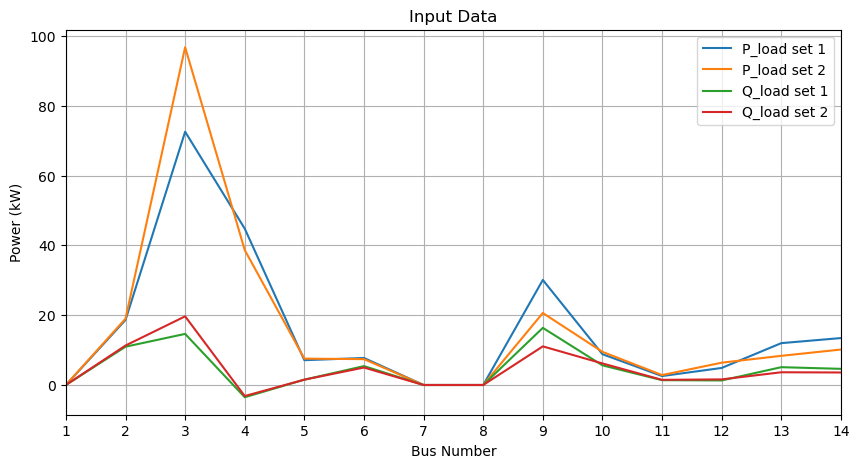

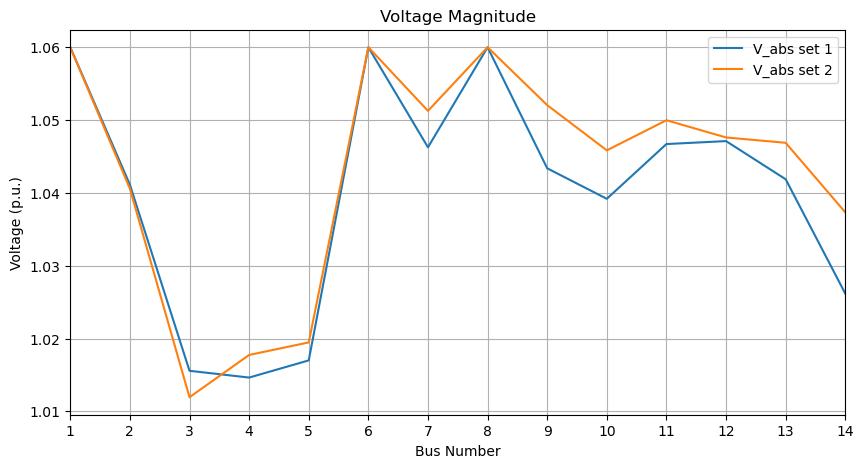

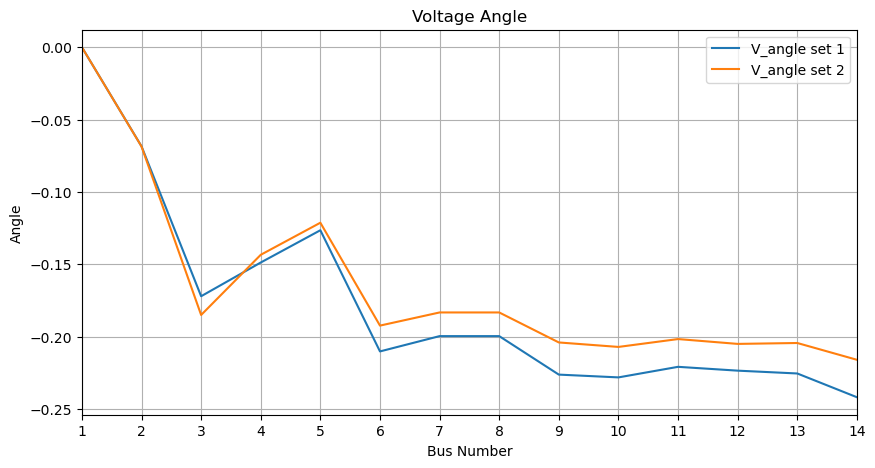

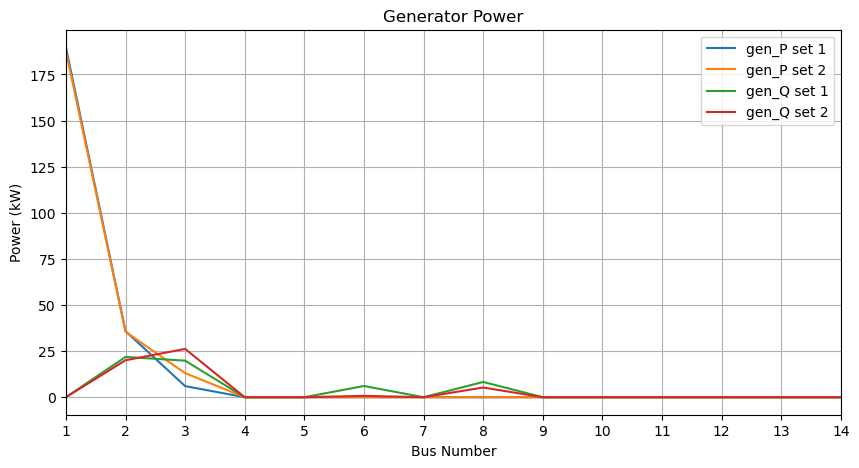

In [3]:
# Plot P_load
plt.figure(figsize=(10, 5))
plt.plot(range(1,15),P_load[0:2,:].T, label='P_load')
plt.plot(range(1,15),Q_load[0:2,:].T, label='Q_load')
plt.title('Input Data')
plt.xlabel('Bus Number')
plt.ylabel('Power (kW)')
plt.xlim(1, 14)
plt.xticks(np.arange(1, 15, 1))
plt.legend(['P_load set 1', 'P_load set 2', 'Q_load set 1', 'Q_load set 2'])
plt.grid()
plt.show()

# Plot V_abs
plt.figure(figsize=(10, 5))
plt.plot(range(1,15),V_abs[0:2,:].T)
plt.title('Voltage Magnitude')
plt.xlabel('Bus Number')
plt.ylabel('Voltage (p.u.)')
plt.xlim(1, 14)
plt.xticks(np.arange(1, 15, 1))
#add legen for each line
plt.legend(['V_abs set 1', 'V_abs set 2'])
plt.grid()
plt.show()

# Plot V_angle
plt.figure(figsize=(10, 5))
plt.plot(range(1,15),V_angle[0:2,:].T, label='V_angle')
plt.title('Voltage Angle')
plt.xlabel('Bus Number')
plt.ylabel('Angle')       
plt.xlim(1, 14)
plt.xticks(np.arange(1, 15, 1))
plt.legend(['V_angle set 1', 'V_angle set 2'])
plt.grid()
plt.show()
# plot gen_P and gen_Q
plt.figure(figsize=(10, 5))
plt.plot(range(1,15),gen_P[0:2,:].T, label='gen_P')
plt.plot(range(1,15),gen_Q[0:2,:].T, label='gen_Q')
plt.title('Generator Power')
plt.xlabel('Bus Number')
plt.ylabel('Power (kW)')
plt.xlim(1, 14)
plt.xticks(np.arange(1, 15, 1))
plt.legend(['gen_P set 1', 'gen_P set 2', 'gen_Q set 1', 'gen_Q set 2'])
plt.grid()
plt.show()



## 3. Covert data to Tensors and Normalization

Convert data to tensors for easy implementation in pytorch 

Normalization using min-max to speed up training and improve model convergence

In [4]:
# 5. Normalize data
def normalize_tensor(tensor, method='minmax'):
    min_val = tensor.min(dim=0, keepdim=True)[0]
    max_val = tensor.max(dim=0, keepdim=True)[0]
    return (tensor - min_val) / (max_val - min_val + 1e-6), min_val, max_val

def unnormalize_tensor(norm_tensor, min_val, max_val, method='minmax'):
    result = norm_tensor * (max_val - min_val + 1e-6) + min_val
    if result.dim() > 1 and result.shape[0] == 1:
        result = result.squeeze(0)
    return result


P_load = torch.tensor(P_load, dtype=torch.float32)
Q_load = torch.tensor(Q_load, dtype=torch.float32)
V_abs = torch.tensor(V_abs, dtype=torch.float32)
V_angle = torch.tensor(V_angle, dtype=torch.float32)
gen_P = torch.tensor(gen_P, dtype=torch.float32)
gen_Q = torch.tensor(gen_Q, dtype=torch.float32)
feasibility = torch.tensor(feasibility, dtype=torch.float32)
objective = torch.tensor(objective, dtype=torch.float32)
Ybus_tensor = torch.tensor(Ybus, dtype=torch.complex64)


P_load_norm, P_min, P_max = normalize_tensor(P_load, 'minmax')
Q_load_norm, Q_min, Q_max = normalize_tensor(Q_load, 'minmax')
V_abs_norm, V_min, V_max = normalize_tensor(V_abs, 'minmax')
V_angle_norm, theta_min, theta_max = normalize_tensor(V_angle, 'minmax')
gen_P_norm, gen_P_min, gen_P_max = normalize_tensor(gen_P, 'minmax')
gen_Q_norm, gen_Q_min, gen_Q_max = normalize_tensor(gen_Q, 'minmax')


## 4. Define the dataset

PowerFlowDataset is a custom dataset class to serve input-output pairs for the neural network. 

In [5]:
class PowerFlowDataset(Dataset):
    def __init__(self, P_load, Q_load, V_abs, V_angle, gen_P, gen_Q): #Store the full dataset
        self.P_load = P_load
        self.Q_load = Q_load
        self.V_abs = V_abs
        self.V_angle = V_angle
        self.gen_P = gen_P
        self.gen_Q = gen_Q

    def __len__(self): #Number of samples
        return self.P_load.shape[0]

    def __getitem__(self, idx): #Get a sample
        load = torch.cat((self.P_load[idx], self.Q_load[idx]), dim=0)
        sample = {
            'load': load,
            'V_opt': self.V_abs[idx],
            'theta_opt': self.V_angle[idx],
            'P_gen': self.gen_P[idx],
            'Q_gen': self.gen_Q[idx],
            'P_load': self.P_load[idx],
            'Q_load': self.Q_load[idx]
        }
        return sample

full_dataset = PowerFlowDataset(P_load_norm, Q_load_norm, V_abs_norm, V_angle_norm, gen_P_norm, gen_Q_norm)
print(f"Total number of samples in dataset: {len(full_dataset)}")

Total number of samples in dataset: 11520


## 5. Split the Data to training/test/validation data

80% of the data for training  and 20% for testing

80% of the traing data for training and 20% for validation


In [6]:
# Choose the split sizes
# 80% for training, 20% for validation
train_size = min(7600, int(0.8 * 9500))
val_size = min(1900, 9000 - train_size)
test_start = 9500
test_size = max(0, len(full_dataset) - test_start)

# Split the dataset into train, validation, and test sets
train_dataset = torch.utils.data.Subset(full_dataset, range(0, train_size))
val_dataset = torch.utils.data.Subset(full_dataset, range(train_size, train_size + val_size))
test_dataset = torch.utils.data.Subset(full_dataset, range(test_start, len(full_dataset)))

#loads the data into batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 6. Define the Neural Network

In [7]:
class BoundsNet(nn.Module):
    def __init__(self, input_dim=28, hidden_dim=128, output_dim=56):
        super(BoundsNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.n_buses = 14

    def forward(self, x):
        return self.model(x)
    
model = BoundsNet()
summary(model, input_size=(28,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           3,712
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 56]           7,224
Total params: 43,960
Trainable params: 43,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.17
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


## 7. Physics-Informed Loss Function

The `physics_informed_loss` function computes a composite loss combining data fidelity, physical constraints, bound violations, and interval width penalties. Below is the mathematical formulation.

### Total Loss
$$ L_{\text{total}} = \lambda_{\text{data}} L_{\text{data}} + \lambda_{\text{phy}} L_{\text{phy}} + \lambda_{\text{bound}} L_{\text{bound}} + \lambda_{\text{width}} L_{\text{width}} $$



### 1. Data Loss
$$ L_{\text{data}} = \frac{1}{ n_{\text{buses}}}  \sum_{j=1}^{n_{\text{buses}}} \left( \max(0, V_{\text{min},j} - V_{j})^2 + \max(0, V_{j} - V_{\text{max},j})^2 \right) $$
$$ + \frac{1}{n_{\text{buses}}}  \sum_{j=1}^{n_{\text{buses}}} \left( \max(0, \theta_{\text{min},j} - \theta_{j})^2 + \max(0, \theta_{j} - \theta_{\text{max},j})^2 \right) $$

### 2. Bound Violation Loss
$$ L_{\text{bound}} = \frac{1}{ n_{\text{buses}}} \sum_{j=1}^{n_{\text{buses}}} \left( \max(0, V_{\text{min},j} - V_{\text{max},j})^2 + \max(0, \theta_{\text{min},j} - \theta_{\text{max},j})^2 \right) $$

### 3. Width Loss
$$ V_{\text{width},j} = V_{\text{max},j} - V_{\text{min},j}, \quad \theta_{\text{width},j} = \theta_{\text{max},j} - \theta_{\text{min},j} $$
$$ L_{\text{width}} = \frac{1}{ n_{\text{buses}}}\sum_{j=1}^{n_{\text{buses}}} \left( V_{\text{width},j}^2 + \theta_{\text{width},j}^2 \right) $$

### 4. Physics Loss

$$ L_{\text{phy}} = \frac{1}{  n_{\text{buses}}}  \sum_{j=1}^{n_{\text{buses}}} \left( (P_{\text{calc},j} - P_{\text{exp},j})^2 + (Q_{\text{calc},j} - Q_{\text{exp},j})^2 \right) $$




In [8]:
def physics_informed_loss(pred_bounds, optimal, load_data, Ybus, lambda_data=30, lambda_phy=1.0, lambda_bound=1, lambda_width=0.008):
    batch_size = pred_bounds.shape[0]
    n_buses = 14
    Vmin = pred_bounds[:, 0:n_buses]
    Vmax = pred_bounds[:, n_buses:2*n_buses]
    theta_min = pred_bounds[:, 2*n_buses:3*n_buses]
    theta_max = pred_bounds[:, 3*n_buses:4*n_buses]

    loss_data = torch.mean(torch.relu(Vmin - optimal['V'])**2 + torch.relu(optimal['V'] - Vmax)**2)
    loss_data += torch.mean(torch.relu(theta_min - optimal['theta'])**2 + torch.relu(optimal['theta'] - theta_max)**2)

    bound_violation_loss = torch.mean(torch.relu(Vmin - Vmax)**2 + torch.relu(theta_min - theta_max)**2)

    V_width = Vmax - Vmin
    theta_width = theta_max - theta_min
    width_loss = torch.mean(V_width**2 + theta_width**2)

    V_mid = (Vmin + Vmax) / 2.0
    theta_mid = (theta_min + theta_max) / 2.0
    G = torch.real(Ybus).clone().detach()
    B = torch.imag(Ybus).clone().detach()
    
    theta_diff = theta_mid.unsqueeze(2) - theta_mid.unsqueeze(1)
    V_prod = V_mid.unsqueeze(2) * V_mid.unsqueeze(1)
    
    P_calc = torch.sum(V_prod * (G * torch.cos(theta_diff) + B * torch.sin(theta_diff)), dim=2)
    Q_calc = torch.sum(V_prod * (G * torch.sin(theta_diff) - B * torch.cos(theta_diff)), dim=2)
    
    P_exp = optimal['P_gen'] - load_data['P_load']
    Q_exp = optimal['Q_gen'] - load_data['Q_load']
    loss_phy = torch.mean((P_calc - P_exp)**2 + (Q_calc - Q_exp)**2)

    total_loss = lambda_data * loss_data + lambda_phy * loss_phy + lambda_bound * bound_violation_loss + lambda_width * width_loss
    return total_loss

## 8. Training Setup

We used Adam Optimizer for training.

We used a learning rate scheduler that reduces the learning rate when the validation loss stops improving.

We also used a custom early stopping mechanism to prevent overfitting. It stops training when validation loss stops improving

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

class EarlyStopping:
    def __init__(self, patience=20, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

## 9. Training Loop

Epoch 1/500, Train Loss: 1.2406, Val Loss: 0.1845, LR: 0.001
Epoch 2/500, Train Loss: 0.1272, Val Loss: 0.1674, LR: 0.001
Epoch 3/500, Train Loss: 0.1206, Val Loss: 0.1765, LR: 0.001
Epoch 4/500, Train Loss: 0.1201, Val Loss: 0.1747, LR: 0.001
Epoch 5/500, Train Loss: 0.1145, Val Loss: 0.1655, LR: 0.001
Epoch 6/500, Train Loss: 0.1142, Val Loss: 0.1717, LR: 0.001
Epoch 7/500, Train Loss: 0.1139, Val Loss: 0.1733, LR: 0.001
Epoch 8/500, Train Loss: 0.1100, Val Loss: 0.1781, LR: 0.001
Epoch 9/500, Train Loss: 0.1077, Val Loss: 0.1817, LR: 0.001
Epoch 10/500, Train Loss: 0.1065, Val Loss: 0.1789, LR: 0.001
Epoch 11/500, Train Loss: 0.1069, Val Loss: 0.1887, LR: 0.001
Epoch 12/500, Train Loss: 0.1064, Val Loss: 0.1876, LR: 0.001
Epoch 13/500, Train Loss: 0.1096, Val Loss: 0.1810, LR: 0.001
Epoch 14/500, Train Loss: 0.1056, Val Loss: 0.1797, LR: 0.001
Epoch 15/500, Train Loss: 0.1062, Val Loss: 0.1775, LR: 0.001
Epoch 16/500, Train Loss: 0.1099, Val Loss: 0.1772, LR: 0.001
Epoch 17/500, Tra

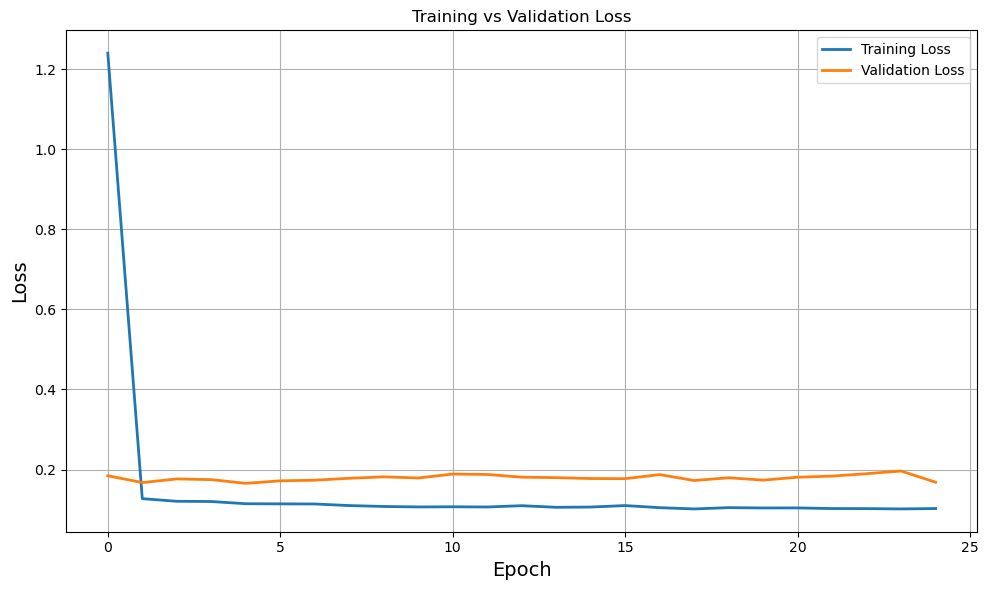

In [10]:
num_epochs = 500 # Set the number of epochs
early_stopper = EarlyStopping(patience=20) # Initialize early stopping
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Minibatch training
    for batch in train_loader:
        inputs = batch['load']
        optimal = {
            'V': batch['V_opt'],
            'theta': batch['theta_opt'],
            'P_gen': batch['P_gen'],
            'Q_gen': batch['Q_gen']
        }
        load_data = {
            'P_load': batch['P_load'],
            'Q_load': batch['Q_load']
        }

        pred_bounds = model(inputs) #predicted bounds
        loss = physics_informed_loss(pred_bounds, optimal, load_data, Ybus_tensor) #calculate loss
        
        optimizer.zero_grad()
        loss.backward() #backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) #gradient clipping
        optimizer.step() #update weights
        train_loss += loss.item() 
        

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['load']
            optimal = {
                'V': batch['V_opt'],
                'theta': batch['theta_opt'],
                'P_gen': batch['P_gen'],
                'Q_gen': batch['Q_gen']
            }
            load_data = {
                'P_load': batch['P_load'],
                'Q_load': batch['Q_load']
            }
            pred_bounds = model(inputs)
            loss = physics_informed_loss(pred_bounds, optimal, load_data, Ybus_tensor) #validation loss
            val_loss += loss.item()
            

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    #scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']}")

    if early_stopper(val_loss):
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 10. Train Linear Regression Model


P_load shape: (11520, 14)
Q_load shape: (11520, 14)
V_abs shape: (11520, 14)
V_angle shape: (11520, 14)
gen_P shape: (11520, 5)
gen_Q shape: (11520, 5)
Total number of samples in dataset: 11520


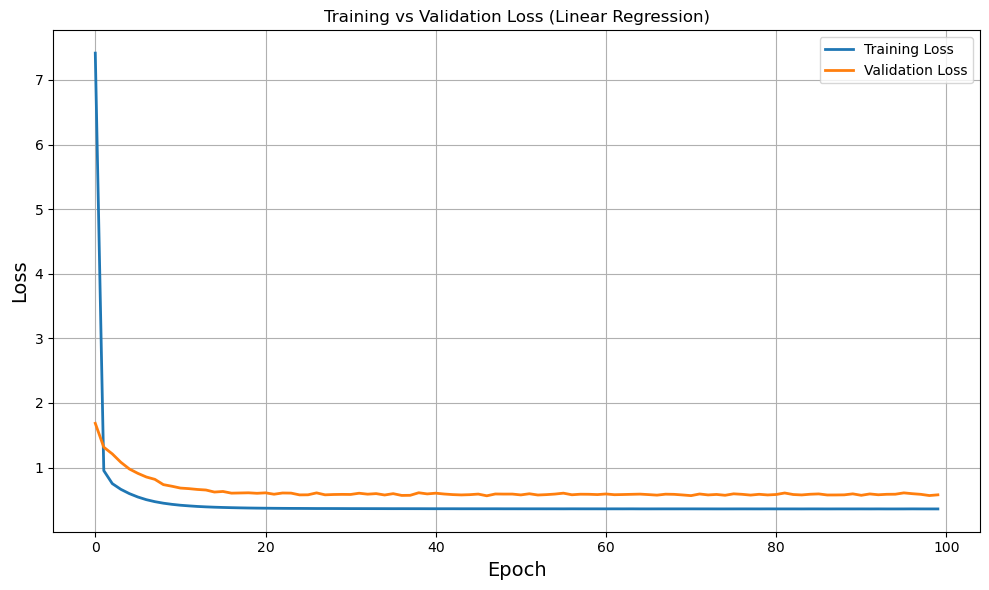

Average Test Loss on samples 9000-end: 0.9803

Percentage of V values within predicted bounds: 53.25%
Percentage of theta values within predicted bounds: 49.99%


In [11]:
from LinearRegression import run_linear_regression_function
train_losses_LR, val_losses_LR,v_bounds_accuracy_LR, theta_bounds_accuracy_LR,avg_test_loss_LR, test_results_LR= run_linear_regression_function()


## 11. Test the Neural Network

We tested 2000 samples using PINN and Linear Regression.

In [12]:
def evaluate_test_set(model, test_loader, Ybus):
    
    model.eval()
    test_loss = 0.0
    all_results = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['load']
            optimal = {
                'V': batch['V_opt'],
                'theta': batch['theta_opt'],
                'P_gen': batch['P_gen'],
                'Q_gen': batch['Q_gen']
            }
            load_data = {
                'P_load': batch['P_load'],
                'Q_load': batch['Q_load']
            }
            
            pred_bounds = model(inputs)
            loss = physics_informed_loss(pred_bounds, optimal, load_data, Ybus)
            test_loss += loss.item()

            # Unnormalize predictions
            num_buses = 14
            Vmin_pred = pred_bounds[:, :num_buses]
            Vmax_pred = pred_bounds[:, num_buses:2*num_buses]
            theta_min_pred = pred_bounds[:, 2*num_buses:3*num_buses]
            theta_max_pred = pred_bounds[:, 3*num_buses:]

            Vmin_pred_unnorm = unnormalize_tensor(Vmin_pred, V_min, V_max, 'minmax')
            Vmax_pred_unnorm = unnormalize_tensor(Vmax_pred, V_min, V_max, 'minmax')
            theta_min_pred_unnorm = unnormalize_tensor(theta_min_pred, theta_min, theta_max, 'minmax')
            theta_max_pred_unnorm = unnormalize_tensor(theta_max_pred, theta_min, theta_max, 'minmax')
            V_opt_unnorm = unnormalize_tensor(optimal['V'], V_min, V_max, 'minmax')
            theta_opt_unnorm = unnormalize_tensor(optimal['theta'], theta_min, theta_max, 'minmax')

            # Process each sample in the batch
            for i in range(inputs.shape[0]):
                P_load_unnorm = unnormalize_tensor(load_data['P_load'][i], P_min, P_max, 'minmax')
                Q_load_unnorm = unnormalize_tensor(load_data['Q_load'][i], Q_min, Q_max, 'minmax')


                V_within_bounds = (Vmin_pred_unnorm[i] <= V_opt_unnorm[i]) & (V_opt_unnorm[i] <= Vmax_pred_unnorm[i])
                theta_within_bounds = (theta_min_pred_unnorm[i] <= theta_opt_unnorm[i]) & (theta_opt_unnorm[i] <= theta_max_pred_unnorm[i])
                
                result = {
                    'P_load': P_load_unnorm.tolist(),
                    'Q_load': Q_load_unnorm.tolist(),
                    'Vmin_pred': Vmin_pred_unnorm[i].tolist(),
                    'V_opt': V_opt_unnorm[i].tolist(),
                    'Vmax_pred': Vmax_pred_unnorm[i].tolist(),
                    'theta_min_pred': theta_min_pred_unnorm[i].tolist(),
                    'theta_opt': theta_opt_unnorm[i].tolist(),
                    'theta_max_pred': theta_max_pred_unnorm[i].tolist(),
                    'V_within_bounds': V_within_bounds.tolist(),
                    'theta_within_bounds': theta_within_bounds.tolist()
                }
                # Verify lengths
                lengths = {k: len(v) for k, v in result.items()}
                assert all(length == num_buses for length in lengths.values()), f"Mismatched lengths in result: {lengths}"
                all_results.append(result)

    avg_test_loss = test_loss / len(test_loader)
    print(f"Average Test Loss on samples 9000-end: {avg_test_loss:.4f}")

    # Create DataFrame for all test results
    results_df = pd.DataFrame(all_results)
    results_df['Sample'] = range(9000, 9000 + len(all_results))
    
    # Explode the columns
    results_df = results_df.explode(['P_load', 'Q_load', 'Vmin_pred', 'V_opt', 'Vmax_pred', 
                                    'theta_min_pred', 'theta_opt', 'theta_max_pred', 
                                    'V_within_bounds', 'theta_within_bounds'])
    results_df['Bus'] = (results_df.groupby('Sample').cumcount() % num_buses) + 1
    
    
    
    # Summary statistics
    v_bounds_accuracy = results_df['V_within_bounds'].mean() * 100
    theta_bounds_accuracy = results_df['theta_within_bounds'].mean() * 100
    print(f"\nPercentage of V values within predicted bounds: {v_bounds_accuracy:.2f}%")
    print(f"Percentage of theta values within predicted bounds: {theta_bounds_accuracy:.2f}%")
    
    return results_df,avg_test_loss

test_results,avg_test_loss = evaluate_test_set(model, test_loader, Ybus_tensor) 


Average Test Loss on samples 9000-end: 0.2856

Percentage of V values within predicted bounds: 85.75%
Percentage of theta values within predicted bounds: 89.05%


## 12. Neural Network vs Linear Regression

In [13]:
results_table = pd.DataFrame({
    'Metric': [
        'Train Loss',
        'Validation Loss',
        'Test Loss',
        'V Bound Accuracy (%)',
        'Theta Bound Accuracy (%)'
    ],
    'Linear Regression': [
        train_losses_LR[-1],
        val_losses_LR[-1],
        avg_test_loss_LR,
        v_bounds_accuracy_LR,
        theta_bounds_accuracy_LR
    ],
    'PINN': [
        train_losses[-1],
        val_losses[-1],
        avg_test_loss,
        test_results['V_within_bounds'].mean() * 100,
        test_results['theta_within_bounds'].mean() * 100
    ]
})

print("\n=== Comparison Table ===")
print(results_table.to_string(index=False))


=== Comparison Table ===
                  Metric  Linear Regression      PINN
              Train Loss           0.360438  0.102499
         Validation Loss           0.578679  0.168264
               Test Loss           0.980307  0.285615
    V Bound Accuracy (%)          53.249646 85.746110
Theta Bound Accuracy (%)          49.989392 89.045262


In [14]:
print("\nTest Set Results (first few samples):")
print(test_results.head(14).to_string(index=False))


Test Set Results (first few samples):
    P_load     Q_load Vmin_pred     V_opt Vmax_pred theta_min_pred theta_opt theta_max_pred V_within_bounds theta_within_bounds  Sample  Bus
       0.0        0.0  1.059993      1.06      1.06      -0.000005       0.0           -0.0            True               False    9000    1
 31.261389  18.158842  1.039341  1.040357  1.044976      -0.072488 -0.071151      -0.053484            True                True    9000    2
 83.358231   15.95683  1.010038  1.017382  1.021472      -0.185232  -0.16532      -0.138409            True                True    9000    3
 51.994419  -4.379307  1.008167  1.015805  1.024431        -0.1537 -0.149574      -0.110895            True                True    9000    4
 10.070855   2.118929  1.011746  1.016968  1.024665      -0.131446  -0.12896      -0.093507            True                True    9000    5
 10.314988   6.856884  1.039464  1.059998  1.060944      -0.219277 -0.217974      -0.163698            True        

## 13. Plot Voltage Bounds for a sample test

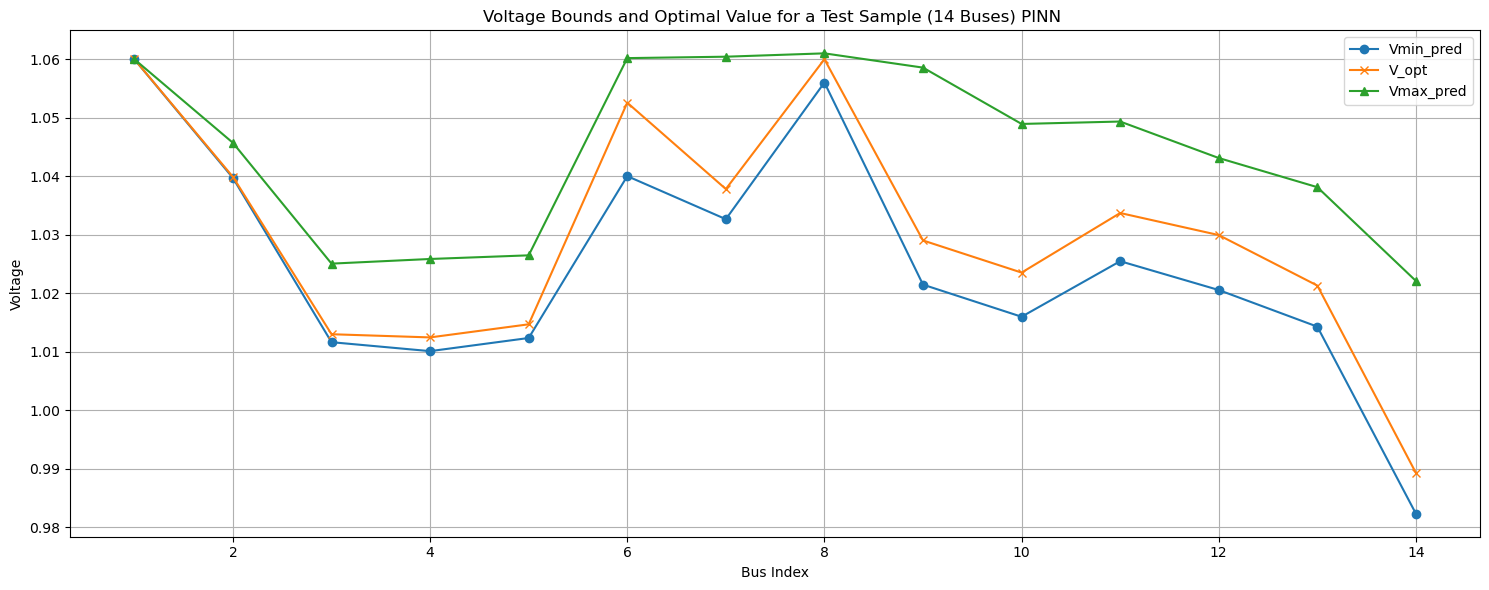

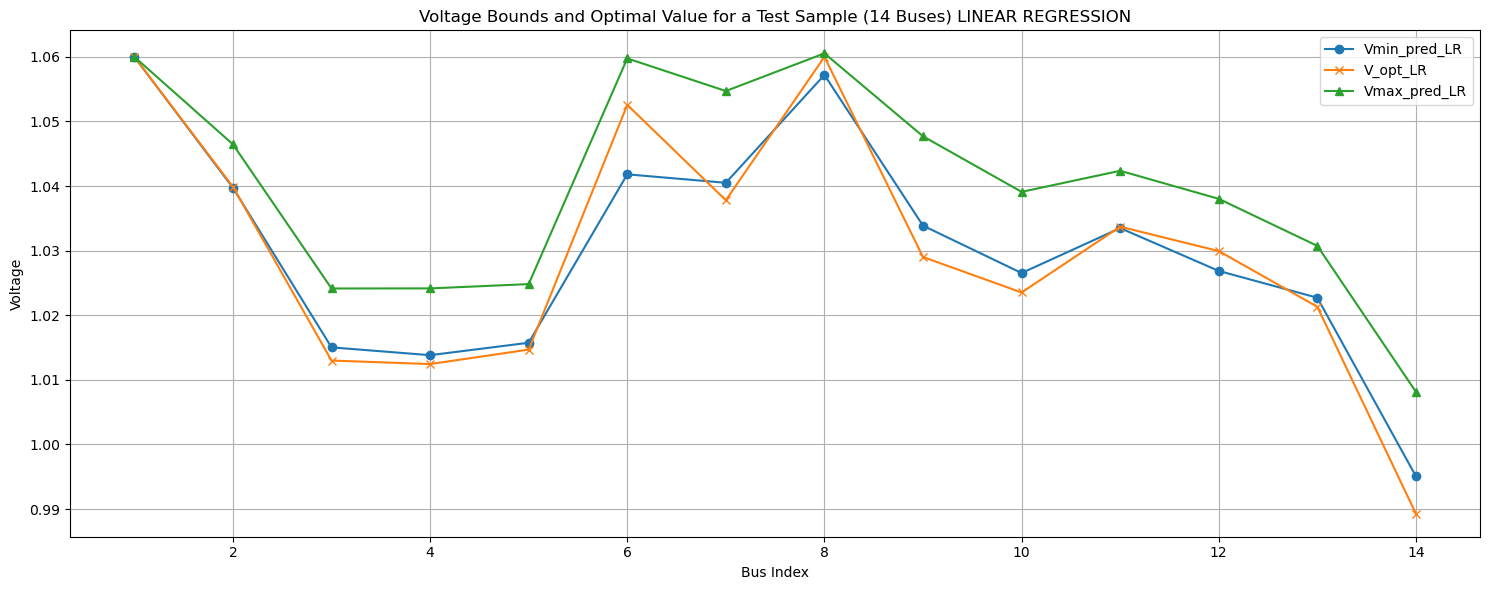

In [23]:
# Plot first 14 samples of V_min_pred, V_opt, Vmax_pred for PINN and Linear Regression
n= 60
n1 = (n)*14
n2 = (n+1)*14
plt.figure(figsize=(15, 6))
plt.plot(test_results['Bus'][n1:n2],test_results['Vmin_pred'][n1:n2], label='Vmin_pred', marker='o')
plt.plot(test_results['Bus'][n1:n2],test_results['V_opt'][n1:n2], label='V_opt', marker='x')
plt.plot(test_results['Bus'][n1:n2],test_results['Vmax_pred'][n1:n2], label='Vmax_pred', marker='^')
plt.xlabel("Bus Index")
plt.ylabel("Voltage")
plt.title("Voltage Bounds and Optimal Value for a Test Sample (14 Buses) PINN ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(test_results_LR['Bus'][n1:n2],test_results_LR['Vmin_pred'][n1:n2], label='Vmin_pred_LR', marker='o')
plt.plot(test_results_LR['Bus'][n1:n2],test_results_LR['V_opt'][n1:n2], label='V_opt_LR', marker='x')
plt.plot(test_results_LR['Bus'][n1:n2],test_results_LR['Vmax_pred'][n1:n2], label='Vmax_pred_LR', marker='^')
plt.xlabel("Bus Index")
plt.ylabel("Voltage")
plt.title("Voltage Bounds and Optimal Value for a Test Sample (14 Buses) LINEAR REGRESSION")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 14. PINN Application for ACOPF

We used our bounds to predict the active bounds in the ACOPF optimization. We run the optimization with all bounds and with only active bounds.

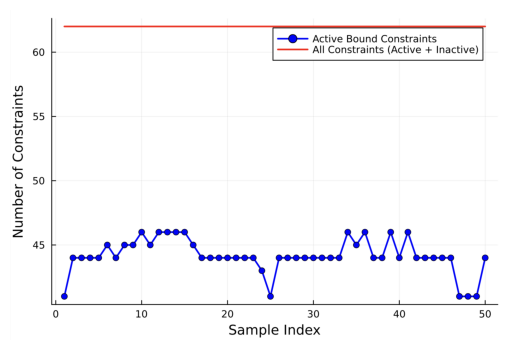

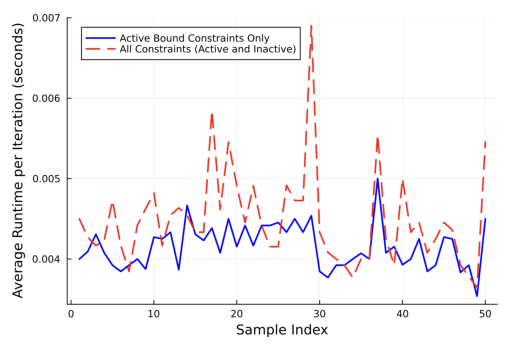

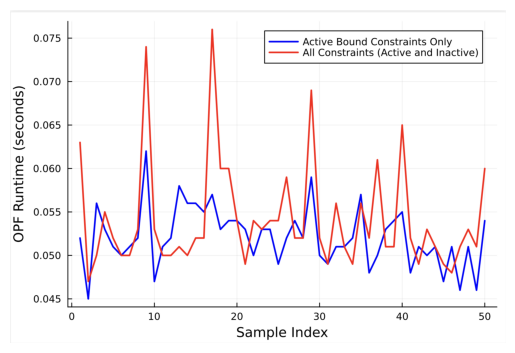

In [ ]:
import matplotlib.image as mpimg

img1 = mpimg.imread('2.png')
img2 = mpimg.imread('1.png')
img3 = mpimg.imread('3.png')  
plt.imshow(img1)
plt.axis('off') 
plt.show()
plt.imshow(img2)
plt.axis('off')  
plt.imshow(img3)
plt.axis('off')  
plt.show()